In [5]:
import os
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision import datasets, models, transforms
import random
import shutil
from PIL import Image

### The Data use in this notebook is from kaggle
### download the data from [kaggle datasets](https://www.kaggle.com/ashishsaxena2209/animal-image-datasetdog-cat-and-panda/download) and unzip
### running the cell below to split data into train and test folders. 
### converts from...
```
animal-image-datasetdog-cat-and-panda
|____animals
     |___cats
             cat001.jpg
             cat002.jpg
             ...
     |___dogs
             dogs001.jpg
             dogs002.jpg
             ...
     |___panda
             panda001.jpg
             ...
|____images
```
### to...
```
animal-image-datasetdog-cat-and-panda/train/
|____animals
        ...
|____train
    |___cats
             cat071.jpg
             cat813.jpg
             ...
     |___dogs
             dogs431.jpg
             dogs144.jpg
             ...
     |___panda
             panda651.jpg
             ...
|____test
    |___cats
             cats342.jpg
             cats715.jpg
             ...
     |___dogs
             dogs545.jpg
             dogs114.jpg
             ...
     |___panda
             panda001.jpg
             ...
|___images
    
```

In [6]:
# below cell is very naive (lolz)... care to implement yours?

In [7]:
def create_train_test(test_ratio:float = 0.2, dataset_dir:str = "animal-image-datasetdog-cat-and-panda"):
    """
    creates a test and train folders based on specified ratio
    with same tree structure as original dataset
    
    :param test_ratio: ratio of the test set
    :type test_ratio: float
    :param dataset_dir: the directory name of the unzipped dataser
    :type dataset_dir: str
    """
    n_test = int(1000 * test_ratio)
    full_dataset_path = os.path.join(os.path.abspath(''), dataset_dir)
    dataset_old_dir = os.path.join(full_dataset_path, "animals")
    dataset_labels = os.listdir(dataset_old_dir)
    
    # creates the train and test dirs in dataset dir
    train_dir = os.path.join(full_dataset_path, "train")
    test_dir = os.path.join(full_dataset_path, "test")
    os.mkdir(test_dir)

    # moving random data to test dirs
    try:
        for label in dataset_labels:
            label_dir = os.path.join(dataset_old_dir, label)
            test_label_dir = os.path.join(test_dir, label)
            if os.path.exists(test_label_dir):
                pass
            else:
                os.mkdir(test_label_dir)

            for n in range(n_test):
                label_images = os.listdir(label_dir)
                an_image = random.choice(label_images)
                image_source_path = os.path.join(label_dir, an_image)
                image_destination_path = os.path.join(test_label_dir, an_image)
                shutil.copy(image_source_path, image_destination_path)
        shutil.copytree(dataset_old_dir, train_dir)
        print(f"Train image path: {train_dir}\n Test image path: {test_dir}")
        print("Sucessful")
        return train_dir, test_dir
    except:
        print("Failed\n")
        raise Exception
                   

In [8]:
train_dir, test_dir = create_train_test()

Train image path: C:\Users\user\Documents\ML works\my_pytorch_work\cat_dog_panda\animal-image-datasetdog-cat-and-panda\train
 Test image path: C:\Users\user\Documents\ML works\my_pytorch_work\cat_dog_panda\animal-image-datasetdog-cat-and-panda\test
Sucessful


In [9]:
train_dir, test_dir

('C:\\Users\\user\\Documents\\ML works\\my_pytorch_work\\cat_dog_panda\\animal-image-datasetdog-cat-and-panda\\train',
 'C:\\Users\\user\\Documents\\ML works\\my_pytorch_work\\cat_dog_panda\\animal-image-datasetdog-cat-and-panda\\test')

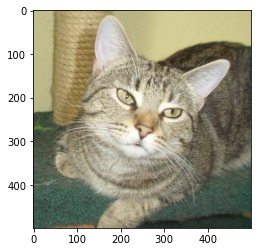

In [12]:
# show a cat random images
train_cat_dir = os.path.join(train_dir, "cats")
cat_image = random.choice(os.listdir(train_cat_dir))
image = Image.open(os.path.join(train_cat_dir, cat_image))
plt.imshow(image)

In [13]:
# image transformations
train_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                      ])
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                     ])

In [14]:
train_folder = datasets.ImageFolder(train_dir, transform=train_transforms)
test_folder = datasets.ImageFolder(test_dir, transform=test_transforms)

In [15]:
train_loader = torch.utils.data.DataLoader(train_folder, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_folder, batch_size=32, shuffle=True)

In [18]:
animal_key = {0: "cat", 1: "dog", 2: "panda"}

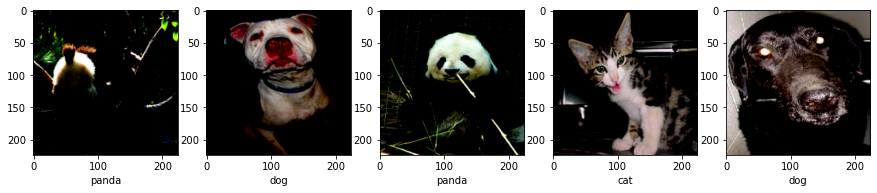

In [19]:
some_images, some_labels = next(iter(test_loader))
figs, axes = plt.subplots(figsize=(15,5), ncols=5)
for i in range(5):
    image = some_images[i].numpy().transpose((1,2,0))
    label = int(some_labels[i].numpy())
    image = np.clip(image, 0, 1)
    ax = axes[i]
    ax.imshow(image)
    ax.set_xlabel(animal_key[label])

In [20]:
# using a pretrained model for feature extraction
densenet_model = models.densenet161(pretrained=True)

In [21]:
densenet_model.classifier

Linear(in_features=2208, out_features=1000, bias=True)

In [22]:
# freezing the pretrained weights
for params in densenet_model.parameters():
    params.requires_grad = False

In [23]:
# creating the classifier model
my_classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(2208, 500)),
                                           ('dropout1', nn.Dropout(p=0.4)),
                                           ('relu1', nn.ReLU()),
                                           ('fc2', nn.Linear(500, 64)),
                                           ('relu2', nn.ReLU()),
                                           ('dropout2', nn.Dropout(p=0.3)),
                                           ('fc3', nn.Linear(64, 3)),
                                           ('output', nn.LogSoftmax(dim=1))
                                          ]))

In [24]:
densenet_model.classifier = my_classifier

In [25]:
# loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(densenet_model.parameters(), lr=0.005)

In [26]:
# number of epochs
epochs = 10

In [27]:
# checking device if GPU is avaible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
device

device(type='cuda')

In [29]:
all_training_loss, all_test_loss, all_test_accuracy = [], [], []

In [30]:
# move model to GPU if available
densenet_model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [31]:
for epoch in range(epochs):
    training_loss = 0
    testing_loss = 0
    testing_accuracy = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = densenet_model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        training_loss += loss.item()
        optimizer.step()
    else:
        densenet_model.eval()
        
        with torch.no_grad():
            for test_images, test_labels in test_loader:
                test_images, test_labels = test_images.to(device), test_labels.to(device)
                log_ps = densenet_model.forward(test_images)
                ps = torch.exp(log_ps)
                test_loss = criterion(log_ps, test_labels)
                testing_loss += test_loss.item()
                
                top_p, top_class = ps.topk(k=1, dim=1)
                accuracy_array = top_class == test_labels.view(*top_class.shape)
                accuracy = torch.mean(accuracy_array.type(torch.FloatTensor))
                testing_accuracy += accuracy.item()
        
        some_log = f"Training loss: {training_loss/len(train_loader):.4f}\t Testing loss {testing_loss/len(test_loader):.4f}\t"
        some_log += f"Testing accuracy: {testing_accuracy/len(test_loader):.4f}"
        print(some_log)
        
        all_training_loss.append(training_loss/len(train_loader))
        all_test_loss.append(testing_loss/len(test_loader))
        all_test_accuracy.append(testing_accuracy/len(test_loader))
        
        densenet_model.train()

Training loss: 0.4423	 Testing loss 0.0572	Testing accuracy: 0.9871
Training loss: 0.2069	 Testing loss 0.0705	Testing accuracy: 0.9776
Training loss: 0.1777	 Testing loss 0.0251	Testing accuracy: 0.9963
Training loss: 0.2045	 Testing loss 0.0409	Testing accuracy: 0.9853
Training loss: 0.1574	 Testing loss 0.0198	Testing accuracy: 0.9908
Training loss: 0.1742	 Testing loss 0.0801	Testing accuracy: 0.9724
Training loss: 0.1792	 Testing loss 0.0221	Testing accuracy: 0.9926
Training loss: 0.1674	 Testing loss 0.0215	Testing accuracy: 0.9908
Training loss: 0.1734	 Testing loss 0.0201	Testing accuracy: 0.9963
Training loss: 0.1261	 Testing loss 0.0169	Testing accuracy: 0.9980


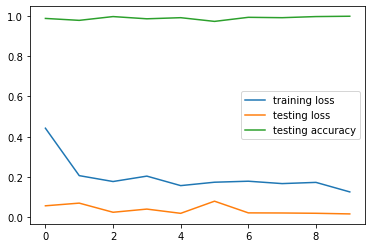

In [32]:
# plotting losses and accuracies
plt.plot(all_training_loss, label="training loss")
plt.plot(all_test_loss, label="testing loss")
plt.plot(all_test_accuracy, label="testing accuracy")
plt.legend()

In [57]:
# testing another new images on model

In [58]:
test_data_path = os.path.join(os.path.abspath(''), "animal-image-datasetdog-cat-and-panda/images/")

In [59]:
image_list = os.listdir(test_data_path)
image_list

['cat.jpg', 'dog.jpg', 'panda.jpg']

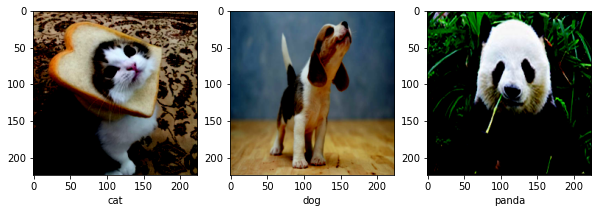

In [106]:
n_test_images = len(image_list)
figs, axes = plt.subplots(figsize=(10,4), ncols=n_test_images)
for i in range(n_test_images):
    ax = axes[i]
    image_PIL = Image.open(os.path.join(test_data_path, image_list[i]))
    image_transformed = test_transforms(image_PIL)
    with torch.no_grad():
        densenet_model.eval()
        densenet_model.to("cpu")
        image_transformed = image_transformed.view((1,3,224,224))
        log_ps = densenet_model.forward(image_transformed)
        ps = torch.exp(log_ps)
        _, prediction = ps.topk(k=1, dim=1)
        prediction = prediction.item()
    image = image_transformed.view((3, 224, 224)).numpy().transpose((1,2,0))
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.set_xlabel(animal_key[prediction])